# Spotting Patterns in Founding Team Formations Using an LSTM Neural Network

In [736]:
# Loads key Python libraries and Deep Learning Frameworks (Keras):

import numpy as np
import csv
import unicodecsv
import pandas as pd
from nltk.tokenize import sent_tokenize
import string
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt

In [737]:
# Uploads the dataset CSV file into arrays X and Y

def read_csv(filename = 'data/sentences_data_v8.csv'):
    sentence = []
    Y_classes = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            sentence.append(row[0])
            Y_classes.append(row[1])
            
    X = np.asarray(sentence)
    Y = np.asarray(Y_classes, dtype = int)

    return X, Y

In [738]:
# Creates dictionaries word_to_vec_map, word_to_index and _index_to_words out of the GloVe 50-dimensional vectors

def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [739]:
# Defines the softmax activation function

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [741]:
# Creates a one-hot vector representation of the Y-labels in the dataset

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    
    return Y

element_dictionary = {"0": "Prior opportunity",
                      "1": "After opportunity",
                      "2": "S-FOCI",
                      "3": "C-FOCI"}

# Loading the GloVe 50-dimensional vectors into its corresponding variables and dictionaries

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

In [742]:
# Loading the training, validation and test sets into their corresponding variables:

X, Y = read_csv('data/sentences_data_v8.csv')
X_train, Y_train = read_csv('data/sentences_data_train_v8.csv')
X_test, Y_test = read_csv('data/sentences_data_test_v8.csv')

In [743]:
# Data cleansing process - eliminating characters that may cause a KeyError message below:

X[0] = X[0].replace('\ufeff', '')
X_train[0] = X_train[0].replace('\ufeff', '')
X_test[0] = X_test[0].replace('\ufeff', '')

# Finding out the max length of any given sentence in the dataset (counting in words) and storing the value in a variable called maxLen

maxLen = len(max(X, key=len).split()) + 1

In [641]:
# Takes the sentences in X and converts its words into an array of indices according to their position in the word_to_index dictionary. Stores indices values in the array X_indices

def sentences_to_indices(X, word_to_index, max_len):
    
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    
    for i in range(m): 
    
        sentence_words = [word.lower().replace('\t', '') for word in X[i].split(' ') if word.replace('\t', '') != '']
        j = 0
        
        for w in sentence_words:
            
            X_indices[i, j] = word_to_index[w]
            j = j + 1
    
    return X_indices

In [642]:
indices = sentences_to_indices(X, word_to_index, maxLen)
print(indices)

[[185457. 170714. 209675. ...      0.      0.      0.]
 [368321. 268046. 254258. ...      0.      0.      0.]
 [ 56041. 103640.  54718. ...      0.      0.      0.]
 ...
 [384374. 385595. 269798. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]]


In [643]:
# Creates the word embedding layer, loaded with pre-trained weights 

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    vocab_len = len(word_to_index) + 1  # adding 1 to fit Keras embedding requirement
    emb_dim = word_to_vec_map["co-founder"].shape[0]
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable = True)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [745]:
# Defines X_train_indices, X_val_indices and X_test_indices and creates one-hot encodings for the Y classes:

X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 4)

X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 4)

In [648]:
# Model architecture: 
# 2 LSTM layers with 130 neurons each
# Dropout value = 0.5
# 1 Dense layer with 4 neurons
# 1 Activation layer with a softmax function

def NLP_model_v1(input_shape, word_to_vec_map, word_to_index):
    
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)  
    
    X = LSTM(130, return_sequences = True)(embeddings)
    X = Dropout(0.5)(X)
    
    X = LSTM(130, return_sequences = False)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(4, activation = None)(X)
    X = Activation('softmax')(X)
    
    model_v1 = Model(sentence_indices, X)
    
    return model_v1

In [649]:
model_v1 = NLP_model_v1((maxLen,), word_to_vec_map, word_to_index)
model_v1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        (None, 40)                0         
_________________________________________________________________
embedding_72 (Embedding)     (None, 40, 50)            20000050  
_________________________________________________________________
lstm_218 (LSTM)              (None, 40, 130)           94120     
_________________________________________________________________
dropout_216 (Dropout)        (None, 40, 130)           0         
_________________________________________________________________
lstm_219 (LSTM)              (None, 130)               135720    
_________________________________________________________________
dropout_217 (Dropout)        (None, 130)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 4)                 524       
__________

In [650]:
# Compiles de NLP model and assigns the loss function and optimizer

model_v1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [651]:
# Fits the NLP model using X_train_indices and Y_train_oh, storing accuracy metrics in a dictionary called mXhistory_dict

history_v1 = model_v1.fit(X_train_indices, Y_train_oh, epochs = 20, batch_size = 30, shuffle = True, validation_split = 0.10)
m1history_dict = history_v1.history
m1history_dict.keys()

Train on 1421 samples, validate on 158 samples
Epoch 1/20
1421/1421 [==============================] - 91s 64ms/step - loss: 1.3590 - acc: 0.3209 - val_loss: 1.2706 - val_acc: 0.4367
Epoch 2/20
1421/1421 [==============================] - 25s 17ms/step - loss: 1.2534 - acc: 0.3871 - val_loss: 1.1955 - val_acc: 0.4367
Epoch 3/20
1421/1421 [==============================] - 24s 17ms/step - loss: 1.1216 - acc: 0.4511 - val_loss: 1.1762 - val_acc: 0.3924
Epoch 4/20
1421/1421 [==============================] - 25s 17ms/step - loss: 1.0270 - acc: 0.5630 - val_loss: 0.9394 - val_acc: 0.6203
Epoch 5/20
1421/1421 [==============================] - 25s 18ms/step - loss: 0.8355 - acc: 0.6791 - val_loss: 0.8150 - val_acc: 0.6582
Epoch 6/20
1421/1421 [==============================] - 24s 17ms/step - loss: 0.7166 - acc: 0.7361 - val_loss: 0.9655 - val_acc: 0.6392
Epoch 7/20
1421/1421 [==============================] - 24s 17ms/step - loss: 0.6027 - acc: 0.7952 - val_loss: 0.7945 - val_acc: 0.7342
E

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [746]:
test_loss_v1, test_acc_v1 = model_v1.evaluate(X_test_indices, Y_test_oh)
print()
print("Test_v1 accuracy = ", test_acc_v1)

31/31 [==============================] - 1s 27ms/step

Test_v1 accuracy =  0.8387096524238586


In [653]:
# Defines the NLP model computing graph architecture, returns model_vX, a Keras instance
# Model architecture: 
# 3 LSTM layers with 100 neurons each
# Dropout value = 0.5
# 1 Dense layer with 4 neurons
# 1 Activation layer with a softmax function

def NLP_model_v2(input_shape, word_to_vec_map, word_to_index):
    
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)  
    
    X = LSTM(100, return_sequences = True)(embeddings)
    X = Dropout(0.5)(X)
    
    X = LSTM(100, return_sequences = True)(X)
    X = Dropout(0.5)(X)
    
    X = LSTM(100, return_sequences = False)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(4, activation = None)(X)
    
    X = Activation('softmax')(X)
    
    model_v2 = Model(sentence_indices, X)
    
    return model_v2

In [654]:
# Compiles de NLP model and assigns the loss function and optimizer

model_v2 = NLP_model_v2((maxLen,), word_to_vec_map, word_to_index)
model_v2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        (None, 40)                0         
_________________________________________________________________
embedding_73 (Embedding)     (None, 40, 50)            20000050  
_________________________________________________________________
lstm_220 (LSTM)              (None, 40, 100)           60400     
_________________________________________________________________
dropout_218 (Dropout)        (None, 40, 100)           0         
_________________________________________________________________
lstm_221 (LSTM)              (None, 40, 100)           80400     
_________________________________________________________________
dropout_219 (Dropout)        (None, 40, 100)           0         
_________________________________________________________________
lstm_222 (LSTM)              (None, 100)               80400     
__________

In [655]:
# Fits the NLP model using X_train_indices and Y_train_oh, storing accuracy metrics in a dictionary called mXhistory_dict

model_v2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [656]:
history_v2 = model_v2.fit(X_train_indices, Y_train_oh, epochs = 20, batch_size = 30, shuffle = False, validation_split = 0.10)
m2history_dict = history_v2.history
m2history_dict.keys()

Train on 1421 samples, validate on 158 samples
Epoch 1/20
1421/1421 [==============================] - 78s 55ms/step - loss: 1.3553 - acc: 0.3047 - val_loss: 1.2574 - val_acc: 0.4430
Epoch 2/20
1421/1421 [==============================] - 26s 18ms/step - loss: 1.2715 - acc: 0.3807 - val_loss: 1.1209 - val_acc: 0.5127
Epoch 3/20
1421/1421 [==============================] - 26s 18ms/step - loss: 1.1149 - acc: 0.5215 - val_loss: 0.9429 - val_acc: 0.6519
Epoch 4/20
1421/1421 [==============================] - 33s 23ms/step - loss: 1.0801 - acc: 0.5130 - val_loss: 1.0087 - val_acc: 0.5696
Epoch 5/20
1421/1421 [==============================] - 35s 24ms/step - loss: 0.8653 - acc: 0.6615 - val_loss: 0.8735 - val_acc: 0.6646
Epoch 6/20
1421/1421 [==============================] - 32s 23ms/step - loss: 0.7491 - acc: 0.7136 - val_loss: 0.8872 - val_acc: 0.6646
Epoch 7/20
1421/1421 [==============================] - 31s 22ms/step - loss: 0.6924 - acc: 0.7452 - val_loss: 0.8786 - val_acc: 0.6835
E

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [747]:
test_loss_v2, test_acc_v2 = model_v2.evaluate(X_test_indices, Y_test_oh)
print()
print("Test_v2 accuracy = ", test_acc_v2)

31/31 [==============================] - 1s 19ms/step

Test_v2 accuracy =  0.6451612710952759


In [658]:
# Defines the NLP model computing graph architecture, returns model_vX, a Keras instance
# Model architecture: 
# 5 LSTM layers with 80 neurons each
# Dropout value = 0.5
# 1 Dense layer with 4 neurons
# 1 Activation layer with a softmax function

def NLP_model_v3(input_shape, word_to_vec_map, word_to_index):

    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)  
    
    X = LSTM(80, return_sequences = True)(embeddings)
    X = Dropout(0.5)(X)
    
    X = LSTM(80, return_sequences = True)(X)
    X = Dropout(0.5)(X)
    
    X = LSTM(80, return_sequences = True)(X)
    X = Dropout(0.5)(X)
    
    X = LSTM(80, return_sequences = True)(X)
    X = Dropout(0.5)(X)
    
    X = LSTM(80, return_sequences = False)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(4, activation = None)(X)
    X = Activation('softmax')(X)
    
    model_v3 = Model(sentence_indices, X)
    
    return model_v3

In [659]:
model_v3 = NLP_model_v3((maxLen,), word_to_vec_map, word_to_index)
model_v3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        (None, 40)                0         
_________________________________________________________________
embedding_74 (Embedding)     (None, 40, 50)            20000050  
_________________________________________________________________
lstm_223 (LSTM)              (None, 40, 80)            41920     
_________________________________________________________________
dropout_221 (Dropout)        (None, 40, 80)            0         
_________________________________________________________________
lstm_224 (LSTM)              (None, 40, 80)            51520     
_________________________________________________________________
dropout_222 (Dropout)        (None, 40, 80)            0         
_________________________________________________________________
lstm_225 (LSTM)              (None, 40, 80)            51520     
__________

In [660]:
model_v3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [661]:
history_v3 = model_v3.fit(X_train_indices, Y_train_oh, epochs = 20, batch_size = 30, shuffle = True, validation_split = 0.10)
m3history_dict = history_v3.history
m3history_dict.keys()

Train on 1421 samples, validate on 158 samples
Epoch 1/20
1421/1421 [==============================] - 100s 70ms/step - loss: 1.3216 - acc: 0.3427 - val_loss: 1.1278 - val_acc: 0.5063
Epoch 2/20
1421/1421 [==============================] - 33s 23ms/step - loss: 1.2340 - acc: 0.4068 - val_loss: 1.1251 - val_acc: 0.3165
Epoch 3/20
1421/1421 [==============================] - 34s 24ms/step - loss: 1.1054 - acc: 0.4391 - val_loss: 1.0002 - val_acc: 0.5696
Epoch 4/20
1421/1421 [==============================] - 31s 22ms/step - loss: 1.0019 - acc: 0.4806 - val_loss: 0.9306 - val_acc: 0.5696
Epoch 5/20
1421/1421 [==============================] - 29s 20ms/step - loss: 0.9058 - acc: 0.6172 - val_loss: 0.8121 - val_acc: 0.6582
Epoch 6/20
1421/1421 [==============================] - 33s 23ms/step - loss: 0.7447 - acc: 0.7248 - val_loss: 0.7779 - val_acc: 0.7278
Epoch 7/20
1421/1421 [==============================] - 31s 22ms/step - loss: 0.6524 - acc: 0.7811 - val_loss: 0.8515 - val_acc: 0.6582


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [748]:
test_loss_v3, test_acc_v3 = model_v3.evaluate(X_test_indices, Y_test_oh)
print()
print("Test_v3 accuracy = ", test_acc_v3)

31/31 [==============================] - 1s 18ms/step

Test_v3 accuracy =  0.6129032373428345


In [663]:
# Defines the NLP model computing graph architecture, returns model_vX, a Keras instance
# Model architecture: 
# 3 LSTM layers with 90 neurons each
# Dropout value = 0.5
# 1 Dense layer with 4 neurons
# 1 Activation layer with a softmax function

def NLP_model_v4(input_shape, word_to_vec_map, word_to_index):
   
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)  
    
    X = LSTM(90, return_sequences = True)(embeddings)
    X = Dropout(0.5)(X)
    
    X = LSTM(90, return_sequences = True)(X)
    X = Dropout(0.5)(X)
    
    X = LSTM(90, return_sequences = False)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(4, activation = None)(X)
    
    X = Activation('softmax')(X)
    
    model_v4 = Model(sentence_indices, X)
    
    return model_v4

In [664]:
model_v4 = NLP_model_v4((maxLen,), word_to_vec_map, word_to_index)
model_v4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        (None, 40)                0         
_________________________________________________________________
embedding_75 (Embedding)     (None, 40, 50)            20000050  
_________________________________________________________________
lstm_228 (LSTM)              (None, 40, 90)            50760     
_________________________________________________________________
dropout_226 (Dropout)        (None, 40, 90)            0         
_________________________________________________________________
lstm_229 (LSTM)              (None, 40, 90)            65160     
_________________________________________________________________
dropout_227 (Dropout)        (None, 40, 90)            0         
_________________________________________________________________
lstm_230 (LSTM)              (None, 90)                65160     
__________

In [665]:
model_v4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [666]:
history_v4 = model_v4.fit(X_train_indices, Y_train_oh, epochs = 20, batch_size = 50, shuffle = False, validation_split = 0.10)
m4history_dict = history_v4.history
m4history_dict.keys()

Train on 1421 samples, validate on 158 samples
Epoch 1/20
1421/1421 [==============================] - 97s 68ms/step - loss: 1.3493 - acc: 0.3181 - val_loss: 1.2976 - val_acc: 0.4367
Epoch 2/20
1421/1421 [==============================] - 18s 13ms/step - loss: 1.3307 - acc: 0.3483 - val_loss: 1.1653 - val_acc: 0.5190
Epoch 3/20
1421/1421 [==============================] - 18s 13ms/step - loss: 1.2073 - acc: 0.4483 - val_loss: 1.1583 - val_acc: 0.4494
Epoch 4/20
1421/1421 [==============================] - 22s 15ms/step - loss: 1.0261 - acc: 0.5841 - val_loss: 0.8642 - val_acc: 0.6456
Epoch 5/20
1421/1421 [==============================] - 21s 15ms/step - loss: 0.8876 - acc: 0.6685 - val_loss: 0.8170 - val_acc: 0.6899
Epoch 6/20
1421/1421 [==============================] - 24s 17ms/step - loss: 0.7257 - acc: 0.7291 - val_loss: 0.8272 - val_acc: 0.7089
Epoch 7/20
1421/1421 [==============================] - 23s 16ms/step - loss: 0.6339 - acc: 0.7825 - val_loss: 0.7957 - val_acc: 0.7405
E

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [749]:
test_loss_v4, test_acc_v4 = model_v4.evaluate(X_test_indices, Y_test_oh)
print()
print("Test_v4 accuracy = ", test_acc_v4)

31/31 [==============================] - 0s 8ms/step

Test_v4 accuracy =  0.6451612710952759


In [668]:
# Defines the NLP model computing graph architecture, returns model_vX, a Keras instance
# Model architecture: 
# 2 LSTM layers with 200 neurons each
# Dropout value = 0.7
# 1 Dense layer with 4 neurons
# 1 Activation layer with a softmax function

def NLP_model_v5(input_shape, word_to_vec_map, word_to_index):

    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)  
    
    X = LSTM(200, return_sequences = True)(embeddings)
    X = Dropout(0.7)(X)
    
    X = LSTM(200, return_sequences = False)(X)
    X = Dropout(0.7)(X)
    
    X = Dense(4, activation = None)(X)
    X = Activation('softmax')(X)
    
    model_v5 = Model(sentence_indices, X)
    
    return model_v5

In [669]:
model_v5 = NLP_model_v5((maxLen,), word_to_vec_map, word_to_index)
model_v5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        (None, 40)                0         
_________________________________________________________________
embedding_76 (Embedding)     (None, 40, 50)            20000050  
_________________________________________________________________
lstm_231 (LSTM)              (None, 40, 200)           200800    
_________________________________________________________________
dropout_229 (Dropout)        (None, 40, 200)           0         
_________________________________________________________________
lstm_232 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_230 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 4)                 804       
__________

In [670]:
model_v5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [671]:
history_v5 = model_v5.fit(X_train_indices, Y_train_oh, epochs = 20, batch_size = 80, shuffle = True, validation_split = 0.10)
m5history_dict = history_v5.history
m5history_dict.keys()

Train on 1421 samples, validate on 158 samples
Epoch 1/20
1421/1421 [==============================] - 101s 71ms/step - loss: 1.3531 - acc: 0.3420 - val_loss: 1.2895 - val_acc: 0.4430
Epoch 2/20
1421/1421 [==============================] - 17s 12ms/step - loss: 1.2383 - acc: 0.4279 - val_loss: 1.1318 - val_acc: 0.4873
Epoch 3/20
1421/1421 [==============================] - 16s 12ms/step - loss: 1.0214 - acc: 0.5771 - val_loss: 0.9550 - val_acc: 0.6646
Epoch 4/20
1421/1421 [==============================] - 16s 12ms/step - loss: 0.9199 - acc: 0.6439 - val_loss: 0.8937 - val_acc: 0.6392
Epoch 5/20
1421/1421 [==============================] - 16s 11ms/step - loss: 0.8312 - acc: 0.6805 - val_loss: 0.8370 - val_acc: 0.6519
Epoch 6/20
1421/1421 [==============================] - 16s 12ms/step - loss: 0.7196 - acc: 0.7248 - val_loss: 0.8550 - val_acc: 0.6899
Epoch 7/20
1421/1421 [==============================] - 16s 12ms/step - loss: 0.6810 - acc: 0.7452 - val_loss: 0.7760 - val_acc: 0.6646


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [750]:
test_loss_v5, test_acc_v5 = model_v5.evaluate(X_test_indices, Y_test_oh)
print()
print("Test_v5 accuracy = ", test_acc_v5)

31/31 [==============================] - 0s 11ms/step

Test_v5 accuracy =  0.7419354915618896


In [673]:
# Defines the NLP model computing graph architecture, returns model_vX, a Keras instance
# Model architecture: 
# 2 LSTM layers with 100 neurons each
# Dropout value = 0.4
# 1 Dense layer with 4 neurons
# 1 Activation layer with a softmax function

def NLP_model_v6(input_shape, word_to_vec_map, word_to_index):

    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)  
    
    X = LSTM(100, return_sequences = True)(embeddings)
    X = Dropout(0.4)(X)
    
    X = LSTM(100, return_sequences = False)(X)
    X = Dropout(0.4)(X)
    
    X = Dense(4, activation = None)(X)
    
    X = Activation('softmax')(X)
    
    model_v6 = Model(sentence_indices, X)
    
    return model_v6

In [674]:
model_v6 = NLP_model_v6((maxLen,), word_to_vec_map, word_to_index)
model_v6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        (None, 40)                0         
_________________________________________________________________
embedding_77 (Embedding)     (None, 40, 50)            20000050  
_________________________________________________________________
lstm_233 (LSTM)              (None, 40, 100)           60400     
_________________________________________________________________
dropout_231 (Dropout)        (None, 40, 100)           0         
_________________________________________________________________
lstm_234 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_232 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 4)                 404       
__________

In [675]:
model_v6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [676]:
history_v6 = model_v6.fit(X_train_indices, Y_train_oh, epochs = 20, batch_size = 32, shuffle = True, validation_split = 0.1)
m6history_dict = history_v6.history
m6history_dict.keys()

Train on 1421 samples, validate on 158 samples
Epoch 1/20
1421/1421 [==============================] - 102s 72ms/step - loss: 1.3569 - acc: 0.3413 - val_loss: 1.3151 - val_acc: 0.4367
Epoch 2/20
1421/1421 [==============================] - 24s 17ms/step - loss: 1.2480 - acc: 0.4370 - val_loss: 1.0508 - val_acc: 0.6013
Epoch 3/20
1421/1421 [==============================] - 22s 15ms/step - loss: 0.9939 - acc: 0.6066 - val_loss: 0.8680 - val_acc: 0.6392
Epoch 4/20
1421/1421 [==============================] - 23s 17ms/step - loss: 0.8376 - acc: 0.6812 - val_loss: 0.7697 - val_acc: 0.7152
Epoch 5/20
1421/1421 [==============================] - 24s 17ms/step - loss: 0.6864 - acc: 0.7664 - val_loss: 0.8189 - val_acc: 0.6835
Epoch 6/20
1421/1421 [==============================] - 24s 17ms/step - loss: 0.6210 - acc: 0.7868 - val_loss: 0.7122 - val_acc: 0.7405
Epoch 7/20
1421/1421 [==============================] - 24s 17ms/step - loss: 0.5434 - acc: 0.8142 - val_loss: 0.7228 - val_acc: 0.7722


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [751]:
test_loss_v6, test_acc_v6 = model_v6.evaluate(X_test_indices, Y_test_oh)
print()
print("Test_v6 accuracy = ", test_acc_v6)

31/31 [==============================] - 0s 6ms/step

Test_v6 accuracy =  0.7096773982048035


In [678]:
loss_values_v1 = m1history_dict['loss']
loss_values_v2 = m2history_dict['loss']
loss_values_v3 = m3history_dict['loss']
loss_values_v4 = m4history_dict['loss']
loss_values_v5 = m5history_dict['loss']
loss_values_v6 = m6history_dict['loss']
val_loss_values_v1 = m1history_dict['val_loss']
val_loss_values_v2 = m2history_dict['val_loss']
val_loss_values_v3 = m3history_dict['val_loss']
val_loss_values_v4 = m4history_dict['val_loss']
val_loss_values_v5 = m5history_dict['val_loss']
val_loss_values_v6 = m6history_dict['val_loss']
acc_v1 = m1history_dict['acc']
acc_v2 = m2history_dict['acc']
acc_v3 = m3history_dict['acc']
acc_v4 = m4history_dict['acc']
acc_v5 = m5history_dict['acc']
acc_v6 = m6history_dict['acc']
val_acc_v1 = m1history_dict['val_acc']
val_acc_v2 = m2history_dict['val_acc']
val_acc_v3 = m3history_dict['val_acc']
val_acc_v4 = m4history_dict['val_acc']
val_acc_v5 = m5history_dict['val_acc']
val_acc_v6 = m6history_dict['val_acc']

epochs = range(1, len(loss_values_v1) + 1)

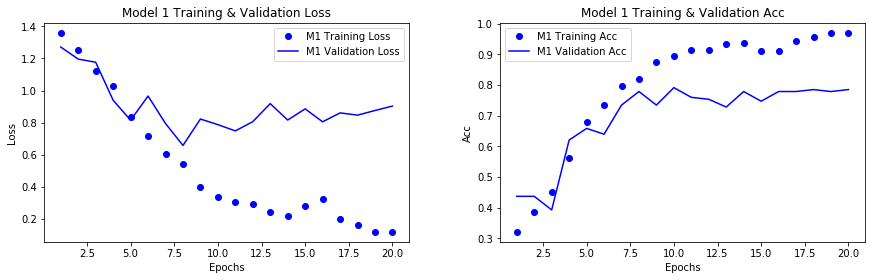

In [679]:
plt.figure(1)

plt.subplot(221)
plt.plot(epochs, loss_values_v1, 'bo', label = 'M1 Training Loss')
plt.plot(epochs, val_loss_values_v1, 'b', label = 'M1 Validation Loss')
plt.title('Model 1 Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(222)
plt.plot(epochs, acc_v1, 'bo', label= "M1 Training Acc")
plt.plot(epochs, val_acc_v1, 'b', label = 'M1 Validation Acc')
plt.title('Model 1 Training & Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.subplots_adjust(top=2, bottom=0.1, left=0.1, right=2, hspace=0.5, wspace=0.25)

plt.show()

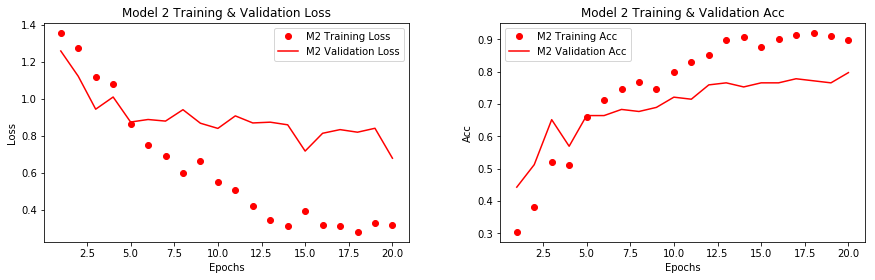

In [680]:
plt.figure(2)

plt.subplot(223)
plt.plot(epochs, loss_values_v2, 'ro', label = 'M2 Training Loss')
plt.plot(epochs, val_loss_values_v2, 'r', label = 'M2 Validation Loss')
plt.title('Model 2 Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(224)
plt.plot(epochs, acc_v2, 'ro', label= "M2 Training Acc")
plt.plot(epochs, val_acc_v2, 'r', label = 'M2 Validation Acc')
plt.title('Model 2 Training & Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.subplots_adjust(top=2, bottom=0.1, left=0.1, right=2, hspace=0.5, wspace=0.25)

plt.show()

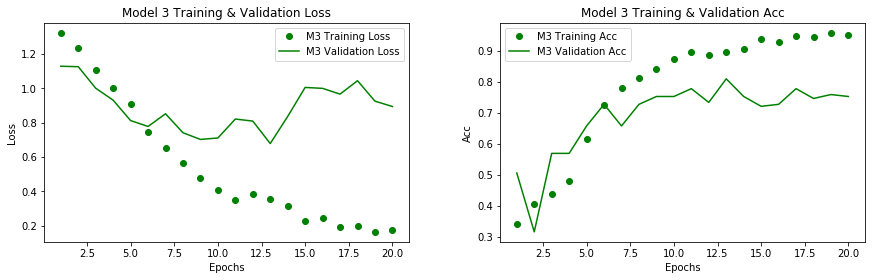

In [681]:
plt.figure(3)

plt.subplot(221)
plt.plot(epochs, loss_values_v3, 'go', label = 'M3 Training Loss')
plt.plot(epochs, val_loss_values_v3, 'g', label = 'M3 Validation Loss')
plt.title('Model 3 Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(222)
plt.plot(epochs, acc_v3, 'go', label= "M3 Training Acc")
plt.plot(epochs, val_acc_v3, 'g', label = 'M3 Validation Acc')
plt.title('Model 3 Training & Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.subplots_adjust(top=2, bottom=0.1, left=0.1, right=2, hspace=0.5, wspace=0.25)

plt.show()

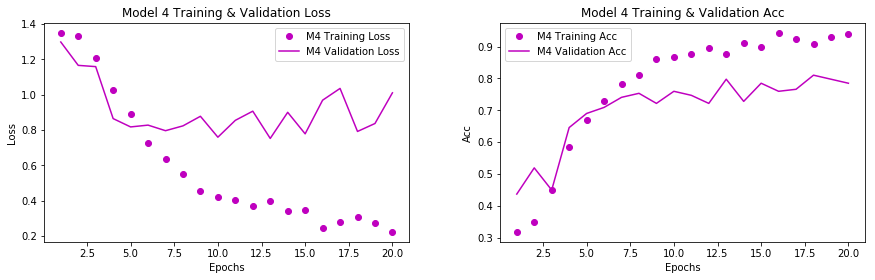

In [682]:
plt.figure(4)

plt.subplot(221)
plt.plot(epochs, loss_values_v4, 'mo', label = 'M4 Training Loss')
plt.plot(epochs, val_loss_values_v4, 'm', label = 'M4 Validation Loss')
plt.title('Model 4 Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(222)
plt.plot(epochs, acc_v4, 'mo', label= "M4 Training Acc")
plt.plot(epochs, val_acc_v4, 'm', label = 'M4 Validation Acc')
plt.title('Model 4 Training & Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.subplots_adjust(top=2, bottom=0.1, left=0.1, right=2, hspace=0.5, wspace=0.25)

plt.show()

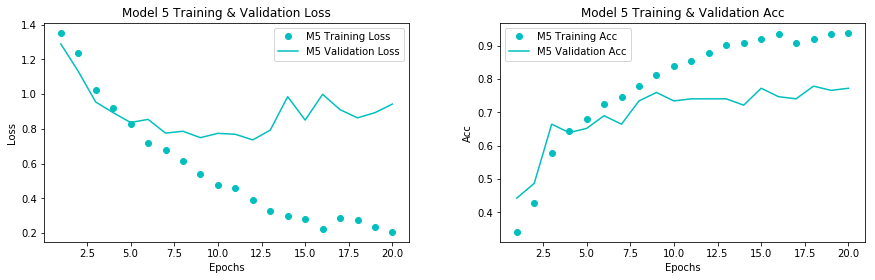

In [683]:
plt.figure(5)

plt.subplot(221)
plt.plot(epochs, loss_values_v5, 'co', label = 'M5 Training Loss')
plt.plot(epochs, val_loss_values_v5, 'c', label = 'M5 Validation Loss')
plt.title('Model 5 Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(222)
plt.plot(epochs, acc_v5, 'co', label= "M5 Training Acc")
plt.plot(epochs, val_acc_v5, 'c', label = 'M5 Validation Acc')
plt.title('Model 5 Training & Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.subplots_adjust(top=2, bottom=0.1, left=0.1, right=2, hspace=0.5, wspace=0.25)

plt.show()

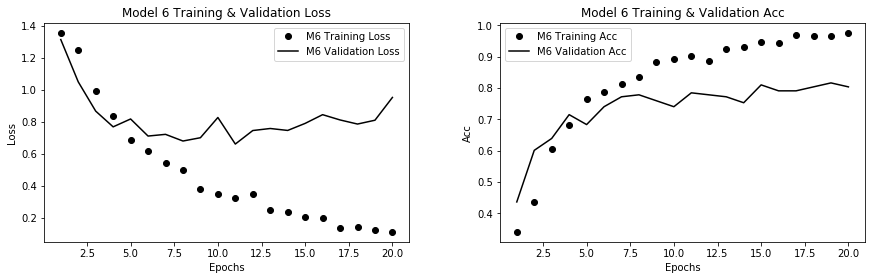

In [684]:
plt.figure(6)

plt.subplot(221)
plt.plot(epochs, loss_values_v6, 'ko', label = 'M6 Training Loss')
plt.plot(epochs, val_loss_values_v6, 'k', label = 'M6 Validation Loss')
plt.title('Model 6 Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(222)
plt.plot(epochs, acc_v6, 'ko', label= "M6 Training Acc")
plt.plot(epochs, val_acc_v6, 'k', label = 'M6 Validation Acc')
plt.title('Model 6 Training & Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.subplots_adjust(top=2, bottom=0.1, left=0.1, right=2, hspace=0.5, wspace=0.25)

plt.show()

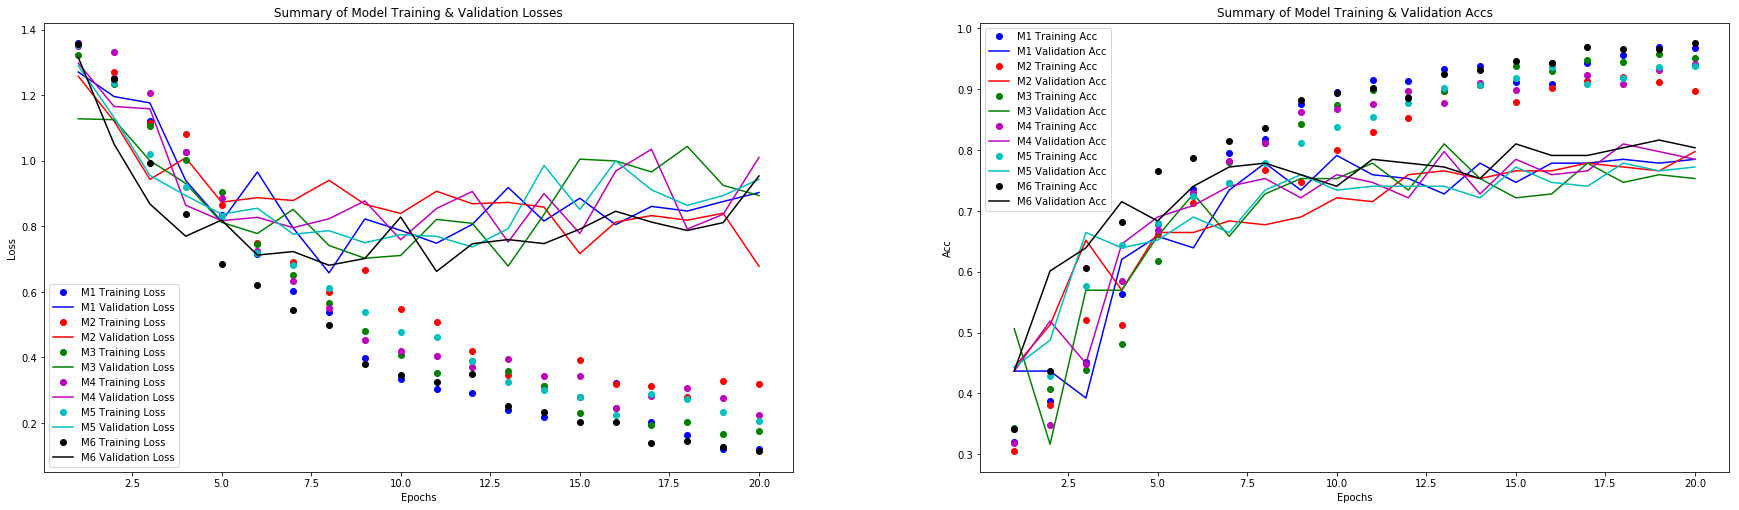

In [685]:
# Consolidates all plots on model performance

plt.figure(7)

plt.subplot(221)
plt.plot(epochs, loss_values_v1, 'bo', label = 'M1 Training Loss')
plt.plot(epochs, val_loss_values_v1, 'b', label = 'M1 Validation Loss')
plt.plot(epochs, loss_values_v2, 'ro', label = 'M2 Training Loss')
plt.plot(epochs, val_loss_values_v2, 'r', label = 'M2 Validation Loss')
plt.plot(epochs, loss_values_v3, 'go', label = 'M3 Training Loss')
plt.plot(epochs, val_loss_values_v3, 'g', label = 'M3 Validation Loss')
plt.plot(epochs, loss_values_v4, 'mo', label = 'M4 Training Loss')
plt.plot(epochs, val_loss_values_v4, 'm', label = 'M4 Validation Loss')
plt.plot(epochs, loss_values_v5, 'co', label = 'M5 Training Loss')
plt.plot(epochs, val_loss_values_v5, 'c', label = 'M5 Validation Loss')
plt.plot(epochs, loss_values_v6, 'ko', label = 'M6 Training Loss')
plt.plot(epochs, val_loss_values_v6, 'k', label = 'M6 Validation Loss')
plt.title('Summary of Model Training & Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(222)
plt.plot(epochs, acc_v1, 'bo', label= 'M1 Training Acc')
plt.plot(epochs, val_acc_v1, 'b', label = 'M1 Validation Acc')
plt.plot(epochs, acc_v2, 'ro', label= 'M2 Training Acc')
plt.plot(epochs, val_acc_v2, 'r', label = 'M2 Validation Acc')
plt.plot(epochs, acc_v3, 'go', label= "M3 Training Acc")
plt.plot(epochs, val_acc_v3, 'g', label = 'M3 Validation Acc')
plt.plot(epochs, acc_v4, 'mo', label= "M4 Training Acc")
plt.plot(epochs, val_acc_v4, 'm', label = 'M4 Validation Acc')
plt.plot(epochs, acc_v5, 'co', label= "M5 Training Acc")
plt.plot(epochs, val_acc_v5, 'c', label = 'M5 Validation Acc')
plt.plot(epochs, acc_v6, 'ko', label= "M6 Training Acc")
plt.plot(epochs, val_acc_v6, 'k', label = 'M6 Validation Acc')
plt.title('Summary of Model Training & Validation Accs')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.subplots_adjust(top=4, bottom=0.1, left=0.1, right=4, hspace=0.5, wspace=0.25)

plt.show()

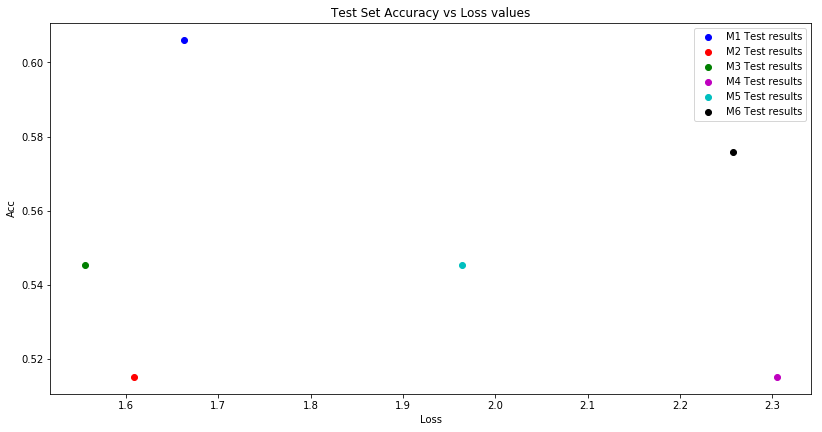

In [686]:
# Creates scatter plot comparing Accuracy and Loss values in the test set

plt.figure(figsize=[30,15])

plt.subplot(222)
plt.plot(test_loss_v1, test_acc_v1, 'bo', label= 'M1 Test results')
plt.plot(test_loss_v2, test_acc_v2, 'ro', label= 'M2 Test results')
plt.plot(test_loss_v3, test_acc_v3, 'go', label= "M3 Test results")
plt.plot(test_loss_v4, test_acc_v4, 'mo', label= "M4 Test results")
plt.plot(test_loss_v5, test_acc_v5, 'co', label= "M5 Test results")
plt.plot(test_loss_v6, test_acc_v6, 'ko', label= "M6 Test results")
plt.title('Test Set Accuracy vs Loss values')
plt.xlabel('Loss')
plt.ylabel('Acc')
plt.legend()

plt.show()

In [ ]:
### EXECUTING THE EXPERIMENT WITH 3 REAL FOUNDER TESTIMONIES IN STRING FORM ###

In [711]:
# Testimony 1 = Drew Houston - Co-founder / Dropbox
testimony1 = "Through a kind of very interesting chain of events I met my cofounder Arash. Actually I put up a screen cast of Dropbox on Hacker News and Arash actually saw it and it turned out. One of the other things I did on this trip five years ago back in March 2007 was come out to meet a bunch of founders and complain how I did not have a cofounder. And it turned out I met someone who was a friend of mine and Arash. And he made an introduction to us and we met up at the MIT Student Center. And hung out for an hour or two and talked about MySQL and some other things and Dropbox. And they were like yeah of course they would want to spend the rest of their waking hours together for the foreseeable future. So kinda like getting married in the first date. But you know if anything does not just an extraordinary lucky break that ended up working out. And we ended up having all these complementary skills and a great relationship. But I would recommend getting to know. Its not the safe way to do it but thats the one probably most important decision you make is who your cofounder is."
# Tokenizes testomony
testimony1_tok = sent_tokenize(testimony1)

# Testimony 2 = Steve Wozniak - Co-founder / Apple
testimony2 = "They way I remember it is that Steve came right out there in front of his house. We were out there on the cul de sac on the sidewalk and we were just talking. We started out by comparing pranks we had done and talking about different types of electronics and chips. We both had a lot of similar experiences so we had a lot to talk about. Then we became best friends for so long. There were not many people that young that knew technology. Steve and I were not similar personalities, which was strange, but Im the sort of person that goes along with anyone that wants to talk technology. And then we both agreed on music too. We had very strong music influences in those days, and it was more songs about living and life and where we are going and where we are from, and what its all about and what works and what doesnt. It was a lot more Bob Dylan stuff than normal popular music that intrigued us. So we would go to concerts. I was going off to Berkeley but I would be down on weekends. Every time I was down we would link up, have a pizza or whatever."
# Tokenizes testomony
testimony2_tok = sent_tokenize(testimony2)

# Testimony 3 = Caterina Fake - Co-founder / Flickr
testimony3 = "Stewart and I are married. When we met, I was living in San Francisco and he lived in Canada. One of his wooing strategies was to suggest that we started a company together. Both of us were doing web development at the time and his idea was that we do some type of transnational web development company, which is kind of a harebrained scheme. We didnt end up doing that, but we did fall in love and have a long distance relationship. I eventually moved up to Vancouver and we got married. We went on our honeymoon and came back and two days later started the company."
# Tokenizes testomony
testimony3_tok = sent_tokenize(testimony3)

In [712]:
# Eliminates punctuation from sentences in the testimony

def eliminate_punct(testimony):
    
    for i in range (len(testimony)):
        punct = str.maketrans(dict.fromkeys(string.punctuation))
        testimony[i] = testimony[i].translate(punct)
        
    return testimony

testimony1_array = eliminate_punct(testimony1_tok)
testimony2_array = eliminate_punct(testimony2_tok)
testimony3_array = eliminate_punct(testimony3_tok)

In [720]:
# Running the NLP model on each testimony

def testimony_analysis(testimony, C):
    
    testimony = eliminate_punct(testimony)
    class_predictions = np.zeros((len(testimony),))
    class_distributions = np.zeros((len(testimony), C))
    
    for i in range (len(testimony)):
        
        sentence_input = np.array([testimony[i]])
        X_indices = sentences_to_indices(sentence_input, word_to_index, maxLen)
        class_predictions[i] = np.argmax(model_v1.predict(X_indices), axis = 1)
        class_distributions[i] = model_v1.predict(X_indices)
    
    return (class_predictions, class_distributions)

In [721]:
# Storing class predictions and distributions in arrays tx_class_predictions and tx_class_distributions

t1_class_predictions, t1_class_distributions = testimony_analysis(testimony1_array, C = 4)
t2_class_predictions, t2_class_distributions = testimony_analysis(testimony2_array, C = 4)
t3_class_predictions, t3_class_distributions = testimony_analysis(testimony3_array, C = 4)

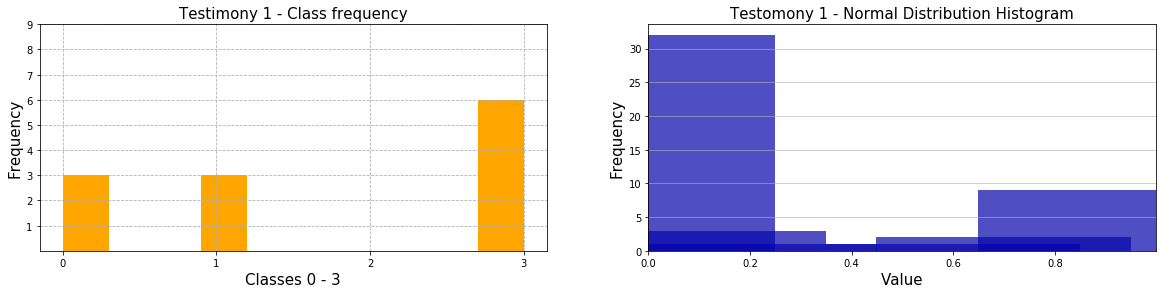

In [722]:
# Plots class frequencies and distributions of Testomony 1

fig = plt.figure(figsize=[20,10])
fig.subplots_adjust(hspace = 0.4, wspace = 0.2)

plt.subplot(221)
plt.hist(t1_class_predictions, color=['orange'], align = 'mid')
plt.xlabel("Classes 0 - 3", fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)
plt.xticks(range(0, 4), fontsize = 10)
plt.yticks(range(1, 10), fontsize = 10)
plt.title('Testimony 1 - Class frequency', fontsize = 15)
plt.grid(True, ls = '--')

plt.subplot(222)
hist1, bin_edges1 = np.histogram(t1_class_distributions)
plt.bar(bin_edges1[:-1], hist1, width = 0.5, color = '#0504aa', alpha = 0.7)
plt.xlim(min(bin_edges1), max(bin_edges1))
plt.grid(axis='y', alpha = 0.75)
plt.xlabel('Value', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Testomony 1 - Normal Distribution Histogram', fontsize = 15)

plt.show()

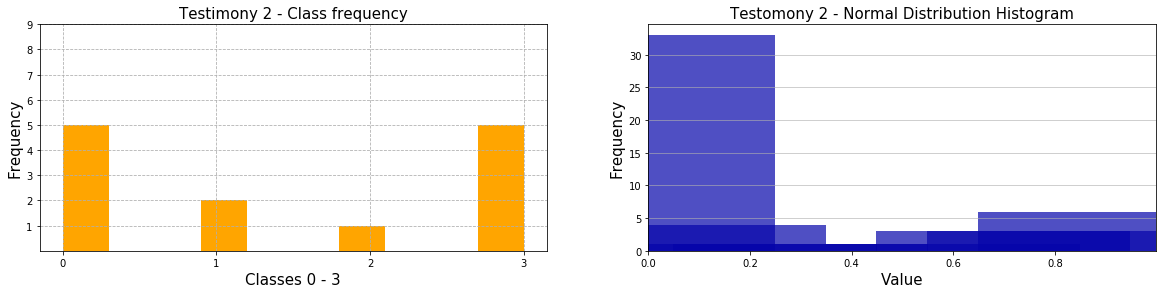

In [723]:
# Plots class frequencies and distributions of Testomony 2

fig = plt.figure(figsize=[20,10])
fig.subplots_adjust(hspace = 0.4, wspace = 0.2)

plt.subplot(221)
plt.hist(t2_class_predictions, color=['orange'])
plt.xlabel("Classes 0 - 3", fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)
plt.xticks(range(0, 4))
plt.yticks(range(1, 10))
plt.title('Testimony 2 - Class frequency', fontsize = 15)
plt.grid(True, ls = '--')

plt.subplot(222)
hist2, bin_edges2 = np.histogram(t2_class_distributions)
plt.bar(bin_edges2[:-1], hist2, width = 0.5, color = '#0504aa', alpha = 0.7)
plt.xlim(min(bin_edges2), max(bin_edges2))
plt.grid(axis='y', alpha = 0.75)
plt.xlabel('Value', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Testomony 2 - Normal Distribution Histogram', fontsize = 15)

plt.show()

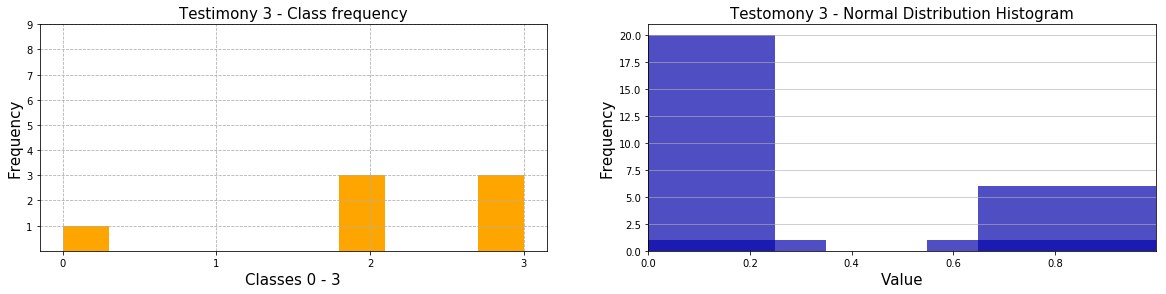

In [724]:
# Plots class frequencies and distributions of Testomony 3

fig = plt.figure(figsize=[20,10])
fig.subplots_adjust(hspace = 0.4, wspace = 0.2)

plt.subplot(221)
plt.hist(t3_class_predictions, color=['orange'])
plt.xlabel("Classes 0 - 3", fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)
plt.xticks(range(0, 4))
plt.yticks(range(1, 10))
plt.title('Testimony 3 - Class frequency', fontsize = 15)
plt.grid(True, ls = '--')

plt.subplot(222)
hist1, bin_edges3 = np.histogram(t3_class_distributions)
plt.bar(bin_edges3[:-1], hist1, width = 0.5, color = '#0504aa', alpha = 0.7)
plt.xlim(min(bin_edges3), max(bin_edges3))
plt.grid(axis='y', alpha = 0.75)
plt.xlabel('Value', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel('Frequency',fontsize = 15)
plt.title('Testomony 3 - Normal Distribution Histogram', fontsize = 15)

plt.show()

In [698]:
### TESTING INDIVIDUAL SENTENCES ###

In [710]:
sentence_test1 = np.array(['Stewart and I are married'])
X_test_indices = sentences_to_indices(sentence_test1, word_to_index, maxLen)
class_prediction1 = np.argmax(model_v1.predict(X_test_indices), axis = 1)
class_distribution1 = model_v1.predict(X_test_indices)
print(class_prediction1)
print(class_distribution1)

[2]
[[0.11350197 0.00255607 0.8657663  0.0181756 ]]


In [700]:
sentence_test2 = np.array(['actually I put up a screen cast of Dropbox on Hacker News and Arash actually saw it and it turned out'])
X_test_indices = sentences_to_indices(sentence_test2, word_to_index, maxLen)
class_prediction2 = np.argmax(model_v1.predict(X_test_indices), axis = 1)
class_distribution2 = model_v1.predict(X_test_indices)
print(class_prediction2)
print(class_distribution2)

[3]
[[1.2244629e-03 8.2924226e-03 1.8406607e-04 9.9029899e-01]]


In [701]:
sentence_test3 = np.array(['One of the other things I did on this trip five years ago back in March 2007 was come out to meet a bunch of founders and complain how I did not have a cofounder'])
X_test_indices = sentences_to_indices(sentence_test3, word_to_index, maxLen)
class_prediction3 = np.argmax(model_v1.predict(X_test_indices), axis = 1)
class_distribution3 = model_v1.predict(X_test_indices)
print(class_prediction3)
print(class_distribution3)

[3]
[[0.01660547 0.18024376 0.0055025  0.79764825]]


In [702]:
sentence_test4 = np.array(['and complain how I did not have a cofounder'])
X_test_indices = sentences_to_indices(sentence_test4, word_to_index, maxLen)
class_prediction4 = np.argmax(model_v1.predict(X_test_indices), axis = 1)
class_distribution4 = model_v1.predict(X_test_indices)
print(class_prediction4)
print(class_distribution4)

[1]
[[2.6964057e-02 9.6791160e-01 5.6322338e-04 4.5611481e-03]]


In [703]:
sentence_test5 = np.array(['We met at the MIT Student Center'])
X_test_indices = sentences_to_indices(sentence_test5, word_to_index, maxLen)
class_prediction5 = np.argmax(model_v1.predict(X_test_indices), axis = 1)
class_distribution5 = model_v1.predict(X_test_indices)
print(class_prediction5)
print(class_distribution5)

[3]
[[2.6921782e-04 1.7766251e-03 4.2390177e-05 9.9791175e-01]]


In [704]:
sentence_test6 = np.array(['and hanged out for an hour or two and talked about database management software'])
X_test_indices = sentences_to_indices(sentence_test6, word_to_index, maxLen)
class_prediction6 = np.argmax(model_v1.predict(X_test_indices), axis = 1)
class_distribution6 = model_v1.predict(X_test_indices)
print(class_prediction6)
print(class_distribution6)

[3]
[[2.7977914e-04 1.8748933e-03 4.4966313e-05 9.9780029e-01]]


In [705]:
sentence_test7 = np.array(['and some other things and Dropbox and they were like yeah we would like to spend the rest of hours together'])
X_test_indices = sentences_to_indices(sentence_test7, word_to_index, maxLen)
class_prediction7 = np.argmax(model_v1.predict(X_test_indices), axis = 1)
class_distribution7 = model_v1.predict(X_test_indices)
print(class_prediction7)
print(class_distribution7)

[0]
[[0.6683467  0.03341096 0.07007885 0.22816354]]


In [706]:
sentence_test8 = np.array(['So kind of like getting married on the first date'])
X_test_indices = sentences_to_indices(sentence_test8, word_to_index, maxLen)
class_prediction8 = np.argmax(model_v1.predict(X_test_indices), axis = 1)
class_distribution8 = model_v1.predict(X_test_indices)
print(class_prediction8)
print(class_distribution8)

[0]
[[0.97687215 0.00262298 0.0097425  0.01076238]]


In [732]:
sentence_test9 = np.array(['And then we both agreed on music too'])
X_test_indices = sentences_to_indices(sentence_test9, word_to_index, maxLen)
class_prediction9 = np.argmax(model_v1.predict(X_test_indices), axis = 1)
class_distribution9 = model_v1.predict(X_test_indices)
print(class_prediction9)
print(class_distribution9)

[1]
[[0.10869367 0.87896913 0.00128691 0.01105027]]


In [735]:
sentence_test10 = np.array(['When we met I was living in San Francisco and he lived in Canada'])
X_test_indices = sentences_to_indices(sentence_test10, word_to_index, maxLen)
class_prediction10 = np.argmax(model_v1.predict(X_test_indices), axis = 1)
class_distribution10 = model_v1.predict(X_test_indices)
print(class_prediction10)
print(class_distribution10)

[3]
[[3.2401373e-04 2.2416397e-03 5.2043957e-05 9.9738234e-01]]


In [733]:
testimony3_array

['Stewart and I are married',
 'When we met I was living in San Francisco and he lived in Canada',
 'One of his wooing strategies was to suggest that we started a company together',
 'Both of us were doing web development at the time and his idea was that we do some type of transnational web development company which is kind of a harebrained scheme',
 'We didnt end up doing that but we did fall in love and have a long distance relationship',
 'I eventually moved up to Vancouver and we got married',
 'We went on our honeymoon and came back and two days later started the company']

In [734]:
t3_class_predictions

array([2., 3., 3., 3., 0., 2., 2.])